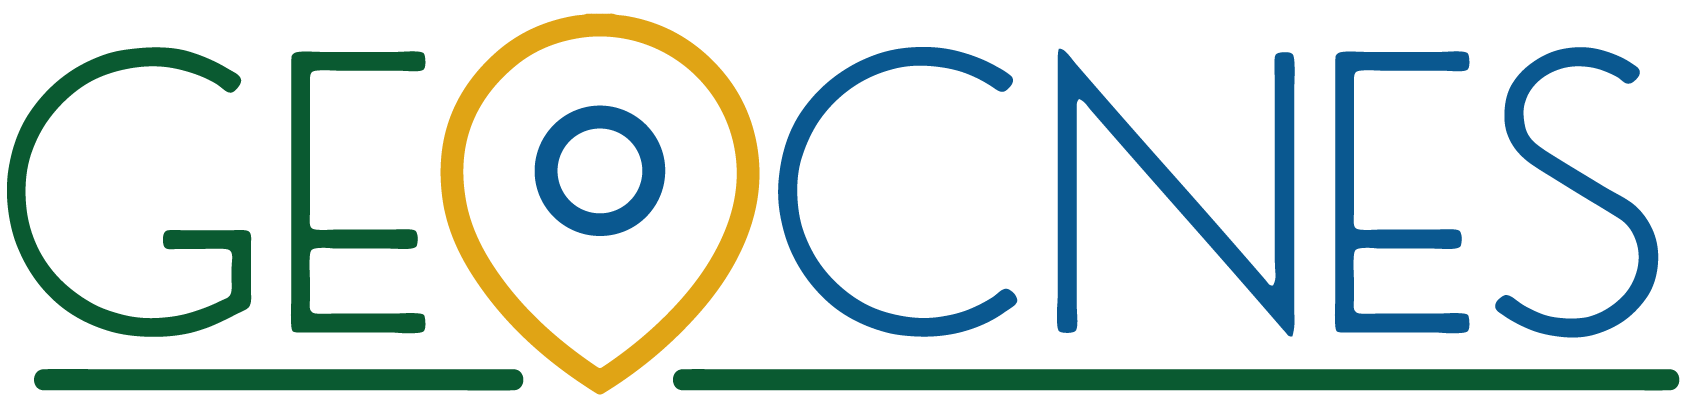

## Bem vindo ao GeoCNES versão 1.0.0!

O GeoCNES é uma ferramenta de código aberto, desenvolvida em Python, que acessa o CNES, e por meio de técnicas de geocodificação permite a geração de mapas interativos para o usuário.

In [32]:
# Definição de algumas variáveis e das bibliotecas utilizadas nessa aplicação.

# Importa a biblioteca de avisos para melhor compreensão da execução das atividades.
import warnings

# Importa a biblioteca para normalização de caracteres Unicode, para tratamento de textos com caracteres especiais.
from unicodedata import normalize

# Importa a função unary_union usada para realizar operações para unir todos os setores censitários e formar os limites do município.
import shapely
from shapely.ops import unary_union

# Importa as classes Point e Polygon usadas para criar objetos geométricos, como pontos e polígonos
from shapely.geometry import Point, Polygon

# Importa bibliotecas para a manipulação de dados geoespaciais, a partir das estruturas da biblioteca Pandas.
import geopandas as gpd
from shapely.geometry import MultiPoint, MultiLineString, MultiPolygon

# Importa bibliotecas para a manipulação de requisições HTTP e arquivos zip junto aos servidores oficiais.
import os
import requests
import urllib
from zipfile import ZipFile
import time

# Importa bibliotecas para a realização da geocodificação das consultas.
import geopy
from geopy.geocoders import Nominatim
from geopy.geocoders import GoogleV3
from geopy.extra.rate_limiter import RateLimiter

# Importa bibliotecas para a armazenamento, a manipulação e a apresentação dos dados utilizados.
import folium
import geoplot as gplt
import geoviews as gv
import geoviews.feature as gf
import imageio
import mapclassify as mc
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pathlib

# Importa bibliotecas para a estimação e a análise das redes de transporte municipais.
import networkx as nx
import osmnx as ox
from shapely.geometry import Point


# Importa bibliotecas gerais para a manipulação de dados e suas estruturas de armazenamento.
import numpy as np
import pandas
import pandas as pd
import xarray as xr

# Importa bibliotecas específicas para a visualização e elaboração de mapas interativos.
import folium
import geoviews.tile_sources as gts

In [33]:
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

In [34]:
path_og = os.getcwd()
print (f'O diretório de trabalho é: {path_og}')

O diretório de trabalho é: C:\Users\lucas


In [35]:
def uf_sigla (code_uf):
    """
    Função: uf_sigla ()
    
    Descição:
    Converte o código númerico de dois digitos de uma unidade federativa brasileira para a sigla correspondente. (Ex: 31 para MG)
    
    Parâmetro:
    - code_uf (str): Código da Unidade Federativa.
    
    Retorno: 
    - sigla (str): Sigla da Unidade Federativa
    """
    sigla = ''
    if (code_uf=='12'): sigla='AC'
    if (code_uf=='27'): sigla='AL'
    if (code_uf=='13'): sigla='AM'
    if (code_uf=='16'): sigla='AP'
    if (code_uf=='29'): sigla='BA'
    if (code_uf=='23'): sigla='CE'
    if (code_uf=='53'): sigla='DF'
    if (code_uf=='32'): sigla='ES'
    if (code_uf=='52'): sigla='GO'
    if (code_uf=='21'): sigla='MA'
    if (code_uf=='31'): sigla='MG'
    if (code_uf=='50'): sigla='MS'
    if (code_uf=='51'): sigla='MT'
    if (code_uf=='15'): sigla='PA'
    if (code_uf=='25'): sigla='PB'
    if (code_uf=='26'): sigla='PE'
    if (code_uf=='22'): sigla='PI'
    if (code_uf=='41'): sigla='PR'
    if (code_uf=='33'): sigla='RJ'
    if (code_uf=='24'): sigla='RN'
    if (code_uf=='11'): sigla='RO'
    if (code_uf=='14'): sigla='RR'
    if (code_uf=='43'): sigla='RS'
    if (code_uf=='42'): sigla='SC'
    if (code_uf=='28'): sigla='SE'
    if (code_uf=='35'): sigla='SP'
    if (code_uf=='17'): sigla='TO'
    return sigla

In [36]:
def ibge_dir ():
    """
    Função: ibge_dir () 
    
    Descição:
    Cria uma nova pasta de trabalho com o nome do código do município, para armazenar os dados baixados.
    """
    
    filename = path_og+'\\GeoCNES\\'+code_mun+'\\'
    if (os.path.exists(filename)==False):
        os.makedirs(filename)
        os.chdir(filename)
    else:
        pass

In [37]:
def ibge_spatial_files (uf):
    """
    Função: ibge_spatial_files ()
    
    Descição:
    Faz o download dos dados espaciais dos setores censitários da unidade da federação utilizada como parâmetro.
    
    Parâmetro:
    - uf (str): Sigla da unidade federativa.
    
    Retorno: 
    - census_tract (gdf): Geodataframe (arquivos geográficos) dos setores censitários de toda unidade da federação do censo do IBGE referentes a 2021.
    """
    
    ibge_dir()
    url = 'https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_de_setores_censitarios__divisoes_intramunicipais/2021/Malha_de_setores_(shp)_por_UFs/'+uf+'/'+uf+'_Setores_2021.zip'
    filename = os.getcwd()+'\\downloaded_files\\'

    #Verifica se uma pasta para download dos arquivos necessários já foi criada, se não a cria.
    if (os.path.exists(filename)==False):
        os.makedirs(filename)
    else:
        pass
    
    filename = os.getcwd()+'\\downloaded_files\\'+uf+'_spatial_data.zip'

    # Verifica se o arquivo do IBGE ainda não foi baixado.
    if (os.path.exists(filename)==False):
        urllib.request.urlretrieve(url, filename)
    else:
        pass
        
    # Descompactação dos dados geográficos.

    fname = [uf+"_Setores_2021.cpg",uf+"_Setores_2021.dbf",uf+"_Setores_2021.prj",uf+"_Setores_2021.shp",uf+"_Setores_2021.shx"] # Lista dos nomes dos arquivos e extensões a serem extraídos
    
    filename = os.getcwd()+'\\downloaded_files\\'+uf+'_spatial_data.zip'
    
    # Verifica se os dados ainda não foram descompactados, caso não tenham sido descompacata-os e armazena na pasta de trabalho.
    if (os.path.exists(filename)==False):
        with ZipFile(filename, 'r') as zObject:
            zObject.extractall(path=(os.getcwd()+'\\downloaded_files\\ext_data\\'), members=fname)
    
    # Efetua a leitura dos dados espaciais como GeoDataFrame
    census_tract = gpd.read_file(os.getcwd()+'\\downloaded_files\\'+uf+'_spatial_data.zip')
    
    return census_tract

In [38]:
def pop_mun (code_mun):
    """
    Função: pop_mun ()
    
    Descição:
    Identifica qual o tamanho da população da cidade de estudo com base nas estimativas do censo do IBGE de 2021. 
    
    Parâmetro:
    - code_mun(str): Código do município com 6 digitos de acordo com o IBGE.
    
    Retorno: 
    - pop (int): Número de habitantes no município de estudo de acordo com as estimativas do censo do IBGE 2021.
    """
    
    # URL para download dos arquivos espaciais
    url = 'https://ftp.ibge.gov.br/Estimativas_de_Populacao/Estimativas_2021/estimativa_dou_2021.xls'
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        r = requests.get(url, verify=False)
    c = r.content
    data_pop = pd.read_excel(c, sheet_name='Municípios', names=['UF', 'COD.UF','COD.MUNIC', 'NOME DO MUNICÍPIO', 'POPULAÇÃO ESTIMADA']) #renomeia o cabeçalho de dados
    data_pop = data_pop.iloc[1:-23, :] #remove a primeira linha antes do cabeçalho e as últimas linhas com notas
    pop = data_pop.loc[data_pop['COD.MUNIC'] == code_mun[-5:],'POPULAÇÃO ESTIMADA'].iloc[0]
    return pop

In [39]:
def census_geo_data (code_mun):
    """
    Função: census_geo_data ()
    
    Descição:
    Faz o download dos dados espaciais dos setores censitários da unidade da federação utilizada como parâmetro.
    
    Parâmetro:
    - code_mun(str): Código do município com 6 digitos de acordo com o IBGE.
    
    Retorno: 
    - setor_censitario (gdf): Geodataframe (arquivos geográficos) dos setores censitários do município de estudo com base no censo do IBGE referentes a 2021.
    """
    
    # Parametro necessário: code_mun
    census_tract = ibge_spatial_files(uf_sigla(code_mun[:len(code_mun)-5]))
    setor_censitario = census_tract.loc[census_tract['CD_MUN']==code_mun]
    return setor_censitario 

In [40]:
def busca_cnes(code_mun, code_un):
    """
    Função: busca_cnes ()
    
    Descição:
    Realiza uma consulta ao CNES e faz o download de uma lista que contem todos os estabelecimentos de saúde de um município.
    
    Parâmetro:
    - code_mun (str): Código do município com 6 digitos de acordo com o IBGE.
    - code_un (str): Código do tipo do estabelecimentos de saúde 2 digitos de acordo com o Ministério da Saúde.
    
    Retorno: 
    - data (df): Um Dataframe com todos os estabelecimentos de saúde do município de estudo antes da limpeza dos dados.
    """

    #Definição do tipo da unidade que se deseja avaliar e da elaboração da URL para efetuar a consulta dos dados no CNES do DATASUS
    
    # Converte o código do município para a sigla da unidade federativa
    code_uf= str(code_mun[:len(code_mun)-5])
    # Converte o código do município para o código do município utilizado no SUS
    code_mun_sus= str(code_mun[:len(code_mun)-1])
            
    # Elaboração da URL para acessar os dados no CNES com os parâmetros específicados
    url = f'https://cnes2.datasus.gov.br/Mod_Ind_Unidade_Listar.asp?VTipo={code_un}&VListar=1&VEstado={code_uf}&VMun={code_mun_sus}&VSubUni=&VComp='
    # Efetua a leitura dos dados diretamente da URL usando a função read_html do pandas
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        r = requests.get(url, verify=False)
    c = r.content
    data = pd.read_html(c)
    return data

In [41]:
def clean_data(data):
    """
    Função: clean_data ()
    
    Descição:
    Prepara os dados brutos obtidos do CNES para utilziação no GeoCNES, removendo linhas desnecessárias e identificando os dados.
    
    Parâmetro:
    - data (df): Dataframe com os estabelecimentos de saúde do município de estudo antes da preparação dos dados.
    
    Retorno: 
    - data (df): Dataframe com os estabelecimentos de saúde do município de estudo após a preparação dos dados.
    """
    # Ajuste da base de dados armazenada.
    data = data[1] # Seleciona a segunda tabela dos dados
    data.columns = data.iloc[0] # Define a primeira linha como cabeçalho das colunas
    data.drop(data.tail(1).index, inplace = True) # Remove o primeiro elemento da lista
    data.drop(data.head(1).index, inplace = True) # Remove o ultimo elemento da lista
    return data

In [42]:
def cnes_tab(code_mun, code_un):
    """
    Função: cnes_tab ()
    
    Descição:
    Executa as funções de busca e preparação dos dados do CNES obtendo o Dataframe final dos estabelecimentos do município.
    
    Parâmetro:
    - code_mun (str): Código do município com 6 digitos de acordo com o IBGE.
    - code_un (str): Código do tipo do estabelecimentos de saúde 2 digitos de acordo com o Ministério da Saúde.
    
    Retorno: 
    - data (df): Dataframe com os códigos do CNES dos estabelecimentos de saúde do município de estudo após a preparação dos dados.
    """
    
    code_uf = code_mun[:len(code_mun)-5] #Define os numeros correspondentes a UF de estudo (str - 2 digitos)
    uf = uf_sigla(code_uf) #define a sigla da uf de estudo (str - 2 digitos)

    ibge_dir() #cria uma nova pasta para o município
    
    data = busca_cnes(code_mun, code_un)

    # Checa se a variável 'data' está vazia ou não
    # Se estiver vazia, possivelmente o município não possui estabelecimentos de saúde desse tipo
    
    if data == []:
        print("Algo não funcionou bem. Verifique o seguinte:\n• O código do município está correto?\n• O código do município está correto?\n• O município possui estabelecimentos do tipo que está sendo analisado?")
        pass
    else:
        pass

    data = clean_data(data)
    return data

In [43]:
def get_cnes(code_url):
    """
    Função: get_cnes ()
    
    Descição:
    Realiza uma consulta ao CNES de um estabelecimentos de saúde para obter o seu endereço. 
    
    Parâmetro:
    - code_url (str): Código CNES do estabelecimento de saúde que é substituído na url para acessar a Ficha Reduzida do Estabelecimento de saúde.
        
    Retorno: 
    - cnes_list (list): Uma lista com nome, logradouro, número, complemento, bairro, cep, município e estado do Estabelecimento de Saúde utilizado como parâmetro. 
    """
    
    session = requests.Session()
    retry = Retry(
        total=5,  # Total number of retries
        backoff_factor=1,  # Wait 1, 2, 4, 8, 16 seconds between retries
        status_forcelist=[500, 502, 503, 504]  # Retry on these HTTP status codes
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)

    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            response = session.get(f'https://cnes2.datasus.gov.br/cabecalho_reduzido.asp?VCod_Unidade={code_url}', verify=False, timeout=10)
        response.raise_for_status()  # Raise HTTPError for bad responses
        c = response.content
        data_cnes = pd.read_html(c)

        data_cnes
        
        data_cnes = data_cnes[2]  # Select the third table from the data

        # Extract specific address data
        nome = data_cnes[0].iloc[1]  # Name of the establishment
        logradouro = data_cnes[0].iloc[5]  # Address of the establishment
        numero = data_cnes[3].iloc[5]  # Number of the establishment
        complemento = data_cnes[0].iloc[7]  # Complement of the establishment
        bairro = data_cnes[1].iloc[7]  # Neighborhood of the establishment
        cep = data_cnes[2].iloc[7]  # ZIP code of the establishment
        municipio = data_cnes[3].iloc[7]  # Municipality of the establishment
        estado = data_cnes[4].iloc[7]  # State of the establishment

        # Concatenate the address into a variable
        if complemento == 'NaN':  # Check if the address does not contain a complement
            endereco = f'{nome}, {logradouro}, {numero}, bairro {bairro}, {cep}, {municipio}, {estado}'
        else:
            endereco = f'{nome}, {logradouro}, {numero}, {complemento}, bairro {bairro}, {cep}, {municipio}, {estado}'

        # Criação de uma lista com o endereço completo do estabelecimento de saúde SEM PROFISSIONAIS
        cnes_list = [nome, logradouro, numero, complemento, bairro, cep, municipio, estado, endereco] #Criação de uma lista com o endereço completo do estabeleciemnto de saúde
        return cnes_list

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None

In [44]:
def cnes_endereco (data):
    """
    Função: cnes_endereco ()
    
    Descição:
    Realiza uma consulta ao CNES de um estabelecimentos de saúde para obter o seu endereço. 
    
    Parâmetro:
    - data (df): Dataframe com os códigos do CNES dos estabelecimentos de saúde do município de estudo após a preparação dos dados.
        
    Retorno: 
    - cnes_mun (Dataframe): Um Dataframe com todos os Estabelecimentos de Saúde de um município e seus respectivos endereços.
    """

    start_time = time.time()
    cnes_mun = pd.DataFrame(columns = ['nome',
                                       'logradouro',
                                       'numero',
                                       'complemento',
                                       'bairro',
                                       'cep',
                                       'municipio',
                                       'estado',
                                       'endereco'])
    
    for i in data.itertuples():
        cod_cnes = i[1]
        cod_url = code_mun[:len(code_mun)-1] + cod_cnes
        temp_list = get_cnes(cod_url)
        if temp_list:
            cnes_mun.loc[len(cnes_mun)] = temp_list
        time.sleep(1)
        #print(f'O estabelecimento {cod_cnes} foi registrado.')
    
    end_time = time.time()
    time_spent = end_time - start_time
    
    print(f'Foram identificados {len(cnes_mun)} establecimentos. O tempo gasto foi de {time_spent} segundos')
    return cnes_mun

In [45]:
def cnes_geocode (cnes_mun, key):
    """
    Função: cnes_geocode ()
    
    Descição:
    Realiza uma consulta ao CNES de um estabelecimentos de saúde para obter o seu endereço. 
    
    Parâmetro:
    - cnes_mun (Dataframe): Um Dataframe com todos os Estabelecimentos de Saúde de um município e seus respectivos endereços.
    - key (str): Variável que armazena a chave de acesso da API da Google que permite a geocodificação dos endereços. 
        
    Retorno: 
    - cnes_mun_gdf (Geodataframe): Geodataframe (arquivos geográficos) dos estabelecimentos de sáude de um município. 
    """
    
    start_time = time.time()
    # Inicialização do georreferenciador do Google
    geopy.geocoders.options.default_user_agent = "my-application" # Define o agente padrão para o processo
    geolocator = GoogleV3(api_key=key) # Define o georreferenciador
    #geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1) # Define um delay para ser efetuado entre os downloads. NÃO SOBRECARREGAR O SERVIDOR.
    
    # Obtém as coordenadas geográficas (latitude, longitude, altitude) para cada endereço
    temp_address = cnes_mun['endereco'].apply(geolocator.geocode)
    cnes_mun['point'] = temp_address.apply(lambda loc: tuple(loc.point) if loc else None)
    
    # Adiciona colunas 'lat', 'lon', 'altitude' ao DataFrame usando as coordenadas obtidas
    cnes_mun[['lat', 'lon', 'altitude']] = pd.DataFrame(cnes_mun['point'].to_list(), index=cnes_mun.index)
    
    # Cria um GeoDataFrame a partir do DataFrame com as coordenadas como pontos de referência
    cnes_mun_gdf = gpd.GeoDataFrame(cnes_mun, geometry = gpd.points_from_xy(cnes_mun.lon, cnes_mun.lat))
    
    end_time =time.time()
    time_spent = end_time - start_time
    
    print (f'Foram geocodificados {len(cnes_mun_gdf)} estabelecimentos. O tempo gasto foi de {time_spent} segundos')
    return cnes_mun_gdf

In [46]:
def cnes_geo(code_mun, key, un_saude_tab):
    """
    Função: cnes_geo ()
    
    Descição:
    Executa as funções responsáveis pela obtenção dos endereços dos centros de saúde e a função para geocodificar estes endereços.  
    
    Parâmetro:
    - cnes_mun (Dataframe): Um Dataframe com todos os Estabelecimentos de Saúde de um município e seus respectivos endereços.
    - key (str): Variável que armazena a chave de acesso da API da Google que permite a geocodificação dos endereços. 
    - un_saude_tab (df): Um Dataframe com todos os Estabelecimentos de Saúde de um município e seus respectivos endereços.
        
    Retorno: 
    - cnes_gdf (Geodataframe): Geodataframe (arquivos geográficos) dos estabelecimentos de sáude de um município. 
    """
    
    cnes_mun = cnes_endereco (un_saude_tab)
    cnes_gdf = cnes_geocode (cnes_mun, key)
    return cnes_gdf    

In [73]:
def mun_ponto (code_mun):
    """
    Função: mun_ponto ()
    Descição: Verifica qual o ponto central do município, a fim de centralizar o mapa final nele e também verificar a qualdiade dos dados geocodificados.
    
    Parâmetro:
    - cnes_mun (Dataframe): Um Dataframe com todos os Estabelecimentos de Saúde de um município e seus respectivos endereços.
    
    Retorno: 
    - mun_pt (Point): O ponto central do mmunicípio.
    """
    
    # Obtém o nome do municípilo, constrói o endereço com base no nome e sigla do estado
    mun = un_saude_geo.municipio.iloc[1]
    mun_endereco = f'{mun},{uf_sigla(code_mun[:len(code_mun)-5])}, Brasil'
    # Realiza a geocodificação do endereço
    geopy.geocoders.options.default_user_agent = "my-application" # Define o agente padrão para o processo
    geolocator = GoogleV3(api_key=google_key) # Define o georreferenciador
    mun_location = geolocator.geocode(mun_endereco) #geocodificação para obter a coordenada do município
    
    mun_loc = gpd.GeoSeries()
    mun_loc ['ponto'] = tuple(mun_location.point) if mun_location else None # se mun_location é um valor único
    mun_loc ['ponto']
    
    mun_loc ['lat'] = mun_loc.get('ponto')[0]
    mun_loc ['lon'] = mun_loc.get('ponto')[1]
    
    # Estabelece um objeto que representa a coordenada central do município
    mun_pt = Point(mun_loc['lon'], mun_loc['lat'])
    return mun_pt

In [70]:
def verif_unidade_centro (code_mun, cnes_mun_gdf):
    """
    Função: verif_unidade_centro ()
    Descição: Verifica qual o ponto central do município, a fim de centralizar o mapa final nele e também verificar a qualdiade dos dados geocodificados.
    
    Parâmetro:
    - code_mun (str): Código do município com 6 digitos de acordo com o IBGE.
    - cnes_mun_gdf (Geodataframe): Um Dataframe com todos os Estabelecimentos de Saúde de um município e seus respectivos endereços.
       
    Retorno: 
    - cnes_mun_gdf (Geodataframe): Um Dataframe com todos os Estabelecimentos de Saúde de um município e seus respectivos endereços, após a verificação.
    """

    mun_pt = mun_ponto(code_mun)
    
    # Verificação se a geolocalização deu certo ou se o ponto está localizado no centro do município 
    idx = 0
    
    for i in cnes_mun_gdf.itertuples(): 
        
        name = i.nome
        ponto = i.geometry
        # Verificação do posicionamento do ponto junto ao município
        # Caso o ponto não corresponder ao centro do município será aceito e o teste irá passar.
        if ((ponto == mun_pt) == False):
            idx +=1
            pass
        # Caso o ponto corresponder ao centro do município o teste irá falhar e deverá ser analisado
        else:
            print(f'Houve algum problema na geocodificação o estabelecimento: {name}, por conta disso ele está mal localizado.')
            print(f'Você deseja: \n[1] Remover o estabelecimento {name} da lista \n[2] Editar manualmente as coordenadas do  estabelecimento {name}\n')
            resposta = input('')
            
        # Opção por eliminar o estabelecimento.
            if(resposta == '1'):
                cnes_mun_gdf = cnes_mun_gdf.drop(idx)
                print(f'Você optou por eliminar o estabelecimento da sua base de dados, dessa forma, o estabelecimento de saúde: {name} foi removido!\n')
                idx +=1
        # Opção por alterar as coordenadas manualmente.    
            elif(resposta == '2'):
                print(f'Você optou por alterar manualmente a coordenada do estabelecimento {name}.\nRecomendamos que você acesse o Google Maps e tente encontrar as coordendas de latitude e longitude do estabelecimento de saúde que apresentou problemas.\n')
                cnes_mun_gdf.loc[idx, 'lat'] = float(input('Insira a coordenada x do estabelecimento:\n'))
                cnes_mun_gdf.loc[idx, 'lon'] = float(input('Insira a coordenada y do estabelecimento:\n'))
                coordinate = [cnes_mun_gdf.loc[idx, 'lon'], cnes_mun_gdf.loc[idx, 'lat']]
                cnes_mun_gdf.loc[idx, 'geometry'] = Point(coordinate)
                print(f'O estabelecimento de saúde: {name} foi corrigido!\n')
                idx += 1
        # Loop para o procedimento.
            else: 
                print(f'Insira 1 para remover o estabelecimento ou 2 para editar suas coordenadas.\n')
        
        return cnes_mun_gdf

In [49]:
def mun_limites (key):
    """
    Função: mun_limites ()
    Descição: Verifica qual o ponto central do município, a fim de centralizar o mapa final nele e também verificar a qualdiade dos dados geocodificados.
    
    Parâmetro:
    - code_mun (str): Código do município com 6 digitos de acordo com o IBGE.
    - cnes_mun_gdf (Geodataframe): Um Dataframe com todos os Estabelecimentos de Saúde de um município e seus respectivos endereços.
       
    Retorno: 
    - cnes_mun_gdf (Geodataframe): Um Dataframe com todos os Estabelecimentos de Saúde de um município e seus respectivos endereços, após a verificação.
    """
    
    # Criação de um polígono (BBox), a partir dos valores mínimos e máximos de longitude e latitude do município, para possibilitar a verficação e visualização. 
    BBox = (un_saude_geo.lon.min(), un_saude_geo.lon.max(), un_saude_geo.lat.min(), un_saude_geo.lat.max())
    
    # Cria um objeto a partir da geometria do estabelecimento de saúde
    estab_saude = MultiPoint(un_saude_geo.geometry)
    
    # Agrupamento dos setores censitários de acordo com sua situação (RURAL/ URBANO)
    set_cens_gdf = gpd.GeoDataFrame(census_geo_data(code_mun))
    grouped_data = set_cens_gdf.groupby("NM_SIT")
    
    # Define o sistema de referência de coordenadas do GeoDataFrame
    un_saude_geo.crs ='EPSG:4674'
    
    # Filtra os setores censitários urbanos
    set_cens_urb_gdf = set_cens_gdf[set_cens_gdf.NM_SIT!='Área Rural (exclusive aglomerados)']
    
    # Remoção de colunas de dados não utilizadas por essa aplicação e remoção de linhas com valores nulos
    set_cens_data = set_cens_gdf.drop(['geometry','NM_SUBDIST'], axis = 1)

    #União (Merge) de todos os setores censitários formando os limites do município
    mun_limits = unary_union(set_cens_gdf.geometry)
    
    return mun_limits

In [50]:
def verif_unidade_fora (cnes_mun_gdf):
    """
    Função: verif_unidade_fora ()
    Descição: Verifica se os Estabelecimentos de Saúde estão dentro dos limites do município.
    
    Parâmetro:
    - cnes_mun_gdf (Geodataframe): Um Dataframe com todos os Estabelecimentos de Saúde de um município e seus respectivos endereços.
       
    Retorno: 
    - cnes_mun_gdf (Geodataframe): Um Dataframe com todos os Estabelecimentos de Saúde de um município e seus respectivos endereços, após a verificação.
    """
    
    # Checagem se o estabelecimento está dentro do limite do município ou não
    mun_limits = mun_limites (google_key)
    
    for i in cnes_mun_gdf.itertuples(): 
        
        name = i.nome
        index = i.Index
           
        # Verificação do posicionamento do estabelecimento junto ao município
        # Caso o estabelecimento esteja na área do município será aceito e o teste irá passar.
        if (mun_limits.contains(i.geometry)==True):
            pass
        # Caso o estabelecimento não esteja no município o teste irá falhar e deverá ser analisado
        else:
            print(f'O estabelecimento {name} está fora da área de estudo.')
            print(f'Você deseja: \n[1] Remover o estabelecimento {name} da lista \n[2] Editar manualmente as coordenadas do  estabelecimento {name}\n')
            resposta = input('')
            # Opção por eliminar o estabelecimento.
            if(resposta == '1'):
                cnes_mun_gdf = cnes_mun_gdf.drop(index)
                print(f'O estabelecimento de saúde: {name} foi removido!\n')
            # Opção por alterar as coordenadas manualmente.     
            elif(resposta == '2'):
                cnes_mun_gdf.loc[index, 'lat'] = float(input('Insira a coordenada x do estabelecimento:\n'))
                cnes_mun_gdf.loc[index, 'lon'] = float(input('Insira a coordenada y do estabelecimento:\n'))
                coordinate = [cnes_mun_gdf.loc[index, 'lon'], cnes_mun_gdf.loc[index, 'lat']]
                cnes_mun_gdf.geometry[index] = Point(coordinate)
                print(f'O estabelecimento de saúde: {name} foi corrigido!\n')
                
            # Loop para o procedimento. 
            else: 
                print(f'Insira 1 para remover o estabelecimento ou 2 para editar suas coordenadas.\n')
            
        return cnes_mun_gdf

In [51]:
def verif_unidade_alt_manual(cnes_mun_gdf,  mudar = 'N'):
    """
    Função: verif_unidade_alt_manual ()
    Descição: Permite que o usuário altere as coordenadas de algum estabelecimento de saúde manualmente.
    
    Parâmetro:
    - cnes_mun_gdf (Geodataframe): Um Dataframe com todos os Estabelecimentos de Saúde de um município e seus respectivos endereços.
    - mudar (str): Parâmetro que define se o usuário deseja fazer mudanças.
       
    Retorno: 
    - cnes_mun_gdf (Geodataframe): Um Dataframe com todos os Estabelecimentos de Saúde de um município e seus respectivos endereços, após a verificação.
    """
    #Checagem com o usuário para alteração manual de coordenadas de algum estabelecimento de saúde
    #mudar = input ('Você deseja alterar as coordenadas de algum Estabelecimento de Saúde? (S/N)')
    while (mudar == 'S'):
        print(f'Os estabelecimentos de saúde da busca são:')
        for i in cnes_mun_gdf.itertuples(): 
            print(f'[{i.Index}] - {i.nome}')
            
        # Escolha do estabelecimento pelo número.
        opcao = input ('Indique o número do estabalecimento que deve ser alterado:')
        opcao = int(opcao)
        
        # Elementos a serem alterados em cada estrutura.
        name = cnes_mun_gdf.nome[opcao]
            
        cnes_mun_gdf.loc[idx, 'lat'] = float(input('Insira a coordenada x do estabelecimento:\n'))
        cnes_mun_gdf.loc[idx, 'lon'] = float(input('Insira a coordenada y do estabelecimento:\n'))
        coordinate = [cnes_mun_gdf.loc[idx, 'lon'], cnes_mun_gdf.loc[idx, 'lat']]
        cnes_mun_gdf.geometry[opcao] = Point(coordinate)
            
        print(f'O estabelecimento de saúde: {name} foi corrigido!\n')
        
        # Entrada para a continuidade do loop para manter alterando as informações.
        mudar = input ('\nVocê deseja alterar as coordenadas de outro Estabelecimento de Saúde? (S/N)')
    return cnes_mun_gdf

In [52]:
def verif_unidade_del (cnes_mun_gdf, mudar = 'N'):
    """
    Função: verif_unidade_del ()
    Descição: Permite que o usuário exclua algum estabelecimento de saúde manualmente.
    
    Parâmetro:
    - cnes_mun_gdf (Geodataframe): Um Dataframe com todos os Estabelecimentos de Saúde de um município e seus respectivos endereços.
    - mudar (str): Parâmetro que define se o usuário deseja fazer mudanças.
       
    Retorno: 
    - cnes_mun_gdf (Geodataframe): Um Dataframe com todos os Estabelecimentos de Saúde de um município e seus respectivos endereços, após a verificação.
    """
    #Checagem com o usuário para remoção manual de algum estabelecimento de saúde
    #mudar = input ('Você deseja remover algum Estabelecimento de Saúde? (S/N)')
    while (mudar == 'S'):
        print(f'Os estabelecimentos de saúde da busca são:')
        for i in cnes_mun_gdf.itertuples(): 
            print(f'[{i.Index}] - {i.nome}')
        
        # Escolha do estabelecimento pelo número.
        opcao = input ('Indique o número do estabalecimento que deve ser removido:')
        opcao = int(opcao)
        
        # Elementos a serem alterados em cada estrutura.
        name = cnes_mun_gdf.nome[opcao]
        
        cnes_mun_gdf = cnes_mun_gdf.drop(opcao)
               
        print(f'O estabelecimento de saúde: {name} foi removido!\n')
        
        # Entrada para a continuidade do loop para manter alterando as informações.
        mudar = input ('\nVocê deseja remover algum outro Estabelecimento de Saúde? (S/N)')
    return cnes_mun_gdf

In [53]:
def verif_unidades (un_saude_geo):
    """
    Função: verif_unidades ()
    Descição: Executa as funções de verificação.
    
    Parâmetro:
    - un_saude_geo (Geodataframe): Um Dataframe com todos os Estabelecimentos de Saúde de um município e seus respectivos endereços.
           
    Retorno: 
    - un_saude_geo (Geodataframe): Um Dataframe com todos os Estabelecimentos de Saúde de um município e seus respectivos endereços, após a verificação.
    """
    
    un_saude_geo = verif_unidade_centro(code_mun, un_saude_geo)
    un_saude_geo = verif_unidade_fora (un_saude_geo)
    un_saude_geo = verif_unidade_alt_manual(un_saude_geo)
    un_saude_geo = verif_unidade_del (un_saude_geo)
    return un_saude_geo

In [56]:
# Verifica, conforme o valor de cnes_tipo, o nível de serviço estudado e retorna a sigla correspondente
def sigla_cnes (cnes_num):
    """
    Função: sigla_unidades ()
    Descição: Identifica qual o código inserido pelo usuário e retorna a sigla correspondente ao tipo de serviço oferecido pelo estabelecimento de saúde. Executa as funções de verificação.
    
    Parâmetro:
    - code_un (str): Código do tipo do estabelecimentos de saúde 2 digitos de acordo com o Ministério da Saúde.
           
    Retorno: 
    - Uma string com a sigla correspondente.
    """
    
    if (cnes_num=="02"):
        return "APS"
    elif (cnes_num=="73"):
        return "ASS"
    elif (cnes_num=="05"):
        return "ATS"

In [57]:
def gerar_mapa(cnes_mun_gdf, set_cens_gdf):
    """
    Função: gerar_mapa ()
    Descição: Identifica qual o código inserido pelo usuário e retorna a sigla correspondente ao tipo de serviço oferecido pelo estabelecimento de saúde. Executa as funções de verificação.
    
    Parâmetro:
    - cnes_mun_gdf (Geodataframe): Um Dataframe com todos os Estabelecimentos de Saúde de um município e seus respectivos endereços.
    - set_cens_gdf (Geodataframe): Geodataframe (arquivos geográficos) dos setores censitários do município de estudo com base no censo do IBGE referentes a 2021.
           
    Retorno: 
    - base_map (map): Mapa interativo da distribuição dos centros de saúde.
    """

    import contextily as ctx
    import geopandas as gpd
    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sns
    from shapely.geometry import Polygon, MultiPolygon
    
    import folium
    from folium.plugins import HeatMap
    
    df_folium = cnes_mun_gdf
    df_folium['weight'] = 1
    
    def generateBaseMap(loc, zoom=12, tiles='CartoDB.Voyager'):
        return folium.Map(location=[mun_ponto (code_mun).y, mun_ponto (code_mun).x],
                       control_scale=True, 
                       zoom_start=zoom,
                       tiles=tiles,
                          width=500,height=500)
    
    
    base_map = generateBaseMap([39,-98])
    
    folium.GeoJson(data=set_cens_gdf, name='My Polygons',
                   style_function=lambda feature: {"fillColor": "grey",
                                                   "color": "black",
                                                   "weight": 0,},
                  
                  ).add_to(base_map)
    
    map_values1 = df_folium[['lat','lon','weight']]
    
    data = map_values1.values.tolist()
               
    hm = HeatMap(data,gradient={0.1: 'blue', 0.3: 'lime', 0.5: 'yellow', 0.7: 'orange', 1: 'red'}, 
                    min_opacity=0.0, 
                    max_opacity=0.8, 
                    radius=30,
                    use_local_extrema=True).add_to(base_map)
    
    for index, row in cnes_mun_gdf.iterrows():
        folium.CircleMarker(location=[row['lat'], row['lon']],
                            radius=3,
                            color='black',
                            fill=True,
                            fillOpacity = 1,
                            popup=f"Name:<br>{row['nome']}").add_to(base_map)
    
    pop = pop_mun(code_mun)
    # Save the map as an HTML file
    base_map.save(f'{un_saude_geo.municipio.iloc[1]}_{sigla_cnes (code_un)}.html')
    print (f'A cidade de {un_saude_geo.municipio.iloc[1]} conta com {len(cnes_mun_gdf)} unidades de {sigla_cnes(code_un)}.\nA razão de estabelecimentos por habitantes é de 1 unidade por {round(pop/len(cnes_mun_gdf))} habitantes\n')
    return base_map.add_child(hm)

In [58]:
def exportacao(cnes_mun_gdf, set_cens_gdf, return_path = path_og):
    """
    Função: exportacao ()
    Descição: Realiza a exportacao dos dados gerados pelo GeoCNES.
    
    Parâmetro:
    - cnes_mun_gdf (Geodataframe): Um Dataframe com todos os Estabelecimentos de Saúde de um município e seus respectivos endereços.
    - set_cens_gdf (Geodataframe): Geodataframe (arquivos geográficos) dos setores censitários do município de estudo com base no censo do IBGE referentes a 2021.
    """

    
    caminho = f"{os.getcwd()}\\{code_mun}"
    
    if (os.path.isdir(caminho) == False):
        os.mkdir(caminho)
        
    cnes_mun_gdf = cnes_mun_gdf.astype(
        {
            "nome": "string",
            "logradouro": "string",
            "numero": "string",
            "complemento": "string",
            "bairro": "string",
            "cep": "string",
            "municipio": "string",
            "estado": "string",
            "endereco": "string",
            "point": "string",
        }
    )

    if ((os.path.isfile(f"{caminho}\\{code_mun}_setores_censitarios.gpkg"))==False):
        set_cens_gdf.to_file(f"{caminho}\\{code_mun}_setores_censitarios.gpkg", driver = "GPKG")

    if ((os.path.isfile(f"{caminho}\\{code_mun}_{code_un}_estab_saude.gpkg"))==False):
        cnes_mun_gdf.to_file(f"{caminho}\\{code_mun}_{code_un}_estab_saude.gpkg", driver = "GPKG")

    os.chdir(path_og)

In [61]:
code_mun= '3205309'
code_un= '05'

    #Nesta célula o usuário deve inserir o código do tipo de estabelecimento a ser analisado, atribuindo à variável cnes_tipo, dentro das aspas, um dos códigos mostrados abaixo:
    # 02 para UBS, USF e Postos de Saúde (APS)
    # 73 para UPAS (ASS)
    # 05 para Hospitais (ATS)
    

un_saude_tab = cnes_tab(code_mun,code_un)

In [66]:
google_key = '' #key da API  do google de geocoding
un_saude_geo = cnes_geo(code_mun, google_key, un_saude_tab)

un_saude_geo = verif_unidades (un_saude_geo)
set_cens = census_geo_data(code_mun)

Foram identificados 12 establecimentos. O tempo gasto foi de 43.826704263687134 segundos
Foram geocodificados 12 estabelecimentos. O tempo gasto foi de 1.6502549648284912 segundos
VITORIA,ES


In [71]:
map = gerar_mapa (un_saude_geo, set_cens)

VITORIA,ES, Brasil
VITORIA,ES, Brasil


C:\Users\lucas\AppData\Local\Temp\ipykernel_5468\4236743385.py:18: FutureWarning: Passing bytes to 'read_excel' is deprecated and will be removed in a future version. To read from a byte string, wrap it in a `BytesIO` object.
  data_pop = pd.read_excel(c, sheet_name='Municípios', names=['UF', 'COD.UF','COD.MUNIC', 'NOME DO MUNICÍPIO', 'POPULAÇÃO ESTIMADA']) #renomeia o cabeçalho de dados


A cidade de VITORIA conta com 12 unidades de ATS.
A razão de estabelecimentos por habitantes é de 1 unidade por 443 habitantes



In [72]:
map

In [336]:
exportacao(un_saude_geo, set_cens)